In [92]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
%autoreload 2

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd as ag

import os
import random

import transformer as T

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   torch.manual_seed(2)
   np.random.seed(2)
   random.seed(2)

In [97]:
model = T.Transformer(2, 32, 128, 2, 0)
src = torch.randn(4, 10, 32)
tgt = torch.randn(4, 10, 32)
padding = torch.zeros(4, 10)
model(src, tgt, padding)
# from  torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter("runs/attention-is-all-you-need")
# writer.add_graph(model, (src, tgt, padding))

tensor([[[ 0.1246,  0.3464, -0.9281,  ...,  0.8902, -0.8681,  0.8323],
         [ 0.9269, -1.0980, -1.1448,  ...,  1.6109, -0.3474,  0.7529],
         [ 1.3838,  0.7746,  1.7188,  ...,  0.9381, -0.2873, -1.6145],
         ...,
         [ 2.7231, -1.6328,  1.1084,  ..., -0.1557,  0.9302,  1.3600],
         [ 0.5085, -1.3287, -0.2097,  ...,  0.9676, -0.9517,  0.9950],
         [-1.1449, -1.9028,  0.1275,  ...,  0.1777, -1.4420,  1.3534]],

        [[-1.2099,  0.6068, -0.2713,  ...,  1.8466, -0.6105,  0.7955],
         [ 0.3712,  1.3587, -0.8205,  ..., -0.7850, -0.7729,  0.2195],
         [ 2.6672, -0.5716,  0.6563,  ...,  0.8172, -0.9564,  0.4257],
         ...,
         [ 2.0405, -0.9435,  1.0818,  ..., -0.8226, -0.3458,  0.5819],
         [ 1.4589, -1.3118,  0.6425,  ...,  1.1617, -0.9473,  1.2531],
         [-0.2570, -1.3208,  1.6688,  ...,  0.4061, -0.3381, -0.3099]],

        [[ 0.6718, -0.0567, -1.0474,  ..., -0.1372, -0.3859,  0.1614],
         [ 1.7405,  0.1853, -0.4685,  ...,  1

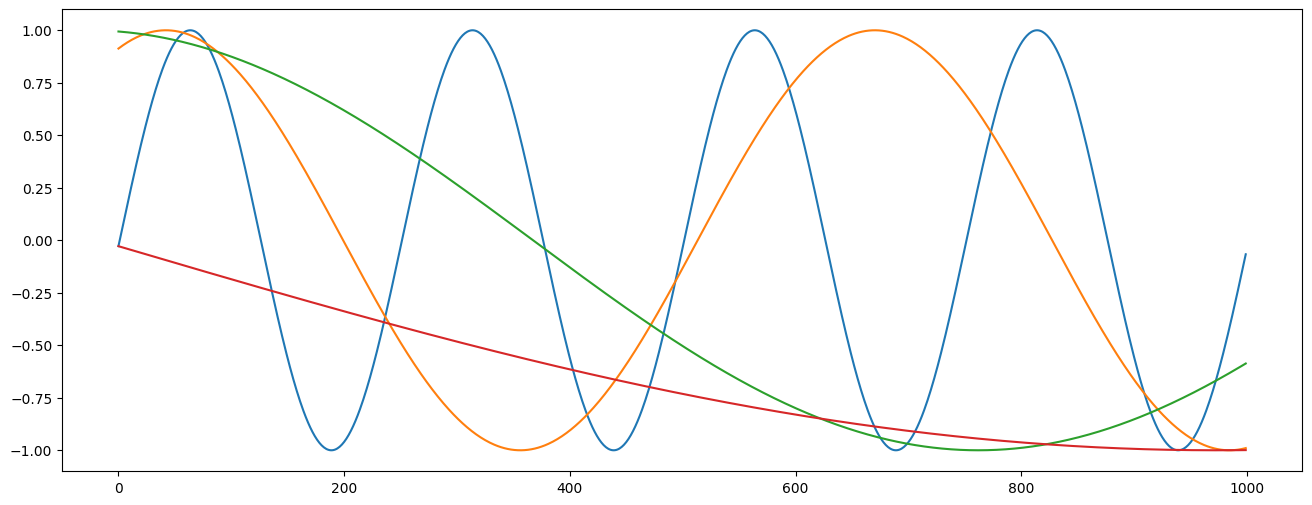

In [105]:
plt.figure(figsize=(16, 6))
pe = T.PositionEncoding()
y = pe.forward(ag.Variable(torch.zeros(1, 1000, 20)))
plt.plot(np.arange(1000), y[0, :, 4:8].data.numpy())

In [13]:
reset_random_seeds()
pe = T.Projection(4, 4)
y = pe(torch.ones(1, 4, 4))
y.shape, torch.finfo(y.dtype).min
# y = pe.forward(torch.zeros(1, 1000, 20))
# plt.plot(np.arange(1000), y[0, :, 3:7].data.numpy())

(torch.Size([1, 4, 4, 1]), -3.4028234663852886e+38)

In [23]:
torch.triu(torch.ones(5, 5), diagonal=1) * torch.finfo(torch.float32).min

tensor([[-0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38],
        [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00]])

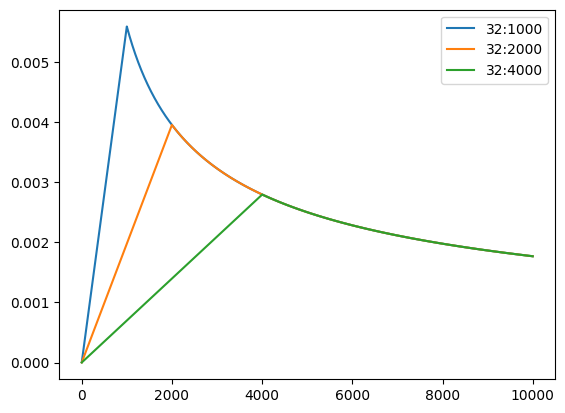

In [60]:
opt = [
    T.ScheduledOptim(32, 1, 1000, None),
    T.ScheduledOptim(32, 1, 2000, None),
    T.ScheduledOptim(32, 1, 4000, None),
    # T.ScheduledOptim(128, 1, 1000, None),
    # T.ScheduledOptim(128, 1, 2000, None),
    # T.ScheduledOptim(128, 1, 4000, None),
    # T.ScheduledOptim(512, 1, 1000, None),
    # T.ScheduledOptim(512, 1, 2000, None),
    # T.ScheduledOptim(512, 1, 4000, None),
]
plt.plot(np.arange(1, 10_000),
         [[o.rate(i) for o in opt] for i in range(1, 10_000)])
plt.legend([
    "32:1000",
    "32:2000",
    "32:4000",
    # "128:1000",
    # "128:2000",
    # "128:4000",
    # "512:1000",
    # "512:2000",
    # "512:4000",
])

In [6]:
def data_gen(vocab_size, batch_size, seq_len, n_batches):
  for _ in range(n_batches):
    data = torch.from_numpy(
        np.random.randint(1, vocab_size, size=(batch_size, seq_len)))
    src = ag.Variable(data, requires_grad=False)
    tgt = ag.Variable(data, requires_grad=False)
    src_mask, tgt_mask = T._mask_op(src, tgt, 0)
    yield src, tgt, src_mask, tgt_mask

In [79]:
e = torch.nn.Embedding(10, 512)
x = torch.randint(0, 10, (4, 20))

In [85]:
e(x).size()
import torch.nn.functional as F

In [88]:
x = torch.randn(4, 10, 32, dtype=torch.float32)
batch_size, length, channels = x.size()
assert channels % 2 == 0, "must use an even number of channels"
position = torch.arange(length).unsqueeze(0) # L,
position = torch.tile(position, (batch_size, 1)) # B, L
num_timescales = channels // 2 # scalar
log_timescale_increment = np.log(1e4) / max(num_timescales - 1, 1) # scalar
inv_timescales = torch.exp(
    torch.arange(num_timescales) * -log_timescale_increment) # C // 2
scaled_time = position.unsqueeze(2) * inv_timescales.reshape(1, 1, -1) # B, L, 1 * 1, 1, C // 2
signal = torch.concat(
    [torch.sin(scaled_time), torch.cos(scaled_time)], dim=2) # B, L, C // 2 * 2
signal

torch.Size([4, 10, 32])


tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.5151,  0.2887,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9093,  0.8831,  0.5528,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.6570, -0.6025,  0.8873,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9894, -0.9275,  0.7164,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4121, -0.9875,  0.4845,  ...,  1.0000,  1.0000,  1.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.5151,  0.2887,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9093,  0.8831,  0.5528,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.6570, -0.6025,  0.8873,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9894, -0.9275,  0.7164,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4121, -0.9875,  0.4845,  ...,  1.0000,  1.0000,  1.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.5151,  0.2887,  ...,  1

In [89]:
y = torch.arange(100)
y

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [90]:
torch.exp(torch.log(y))

tensor([ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
         8.0000,  9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000,
        16.0000, 17.0000, 18.0000, 19.0000, 20.0000, 21.0000, 22.0000, 23.0000,
        24.0000, 25.0000, 26.0000, 27.0000, 28.0000, 29.0000, 30.0000, 31.0000,
        32.0000, 33.0000, 34.0000, 35.0000, 36.0000, 37.0000, 38.0000, 39.0000,
        40.0000, 41.0000, 42.0000, 43.0000, 44.0000, 45.0000, 46.0000, 47.0000,
        48.0000, 49.0000, 50.0000, 51.0000, 52.0000, 53.0000, 54.0000, 55.0000,
        56.0000, 57.0000, 58.0000, 59.0000, 60.0000, 61.0000, 62.0000, 63.0000,
        64.0000, 65.0000, 66.0000, 67.0000, 68.0000, 69.0000, 70.0000, 71.0000,
        72.0000, 73.0000, 74.0000, 75.0000, 76.0000, 77.0000, 78.0000, 79.0000,
        80.0000, 81.0000, 82.0000, 83.0000, 84.0000, 85.0000, 86.0000, 87.0000,
        88.0000, 89.0000, 90.0000, 91.0000, 92.0000, 93.0000, 94.0000, 95.0000,
        96.0000, 97.0000, 98.0000, 99.00

In [91]:
torch.log(torch.exp(y))

tensor([ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
         8.0000,  9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000,
        16.0000, 17.0000, 18.0000, 19.0000, 20.0000, 21.0000, 22.0000, 23.0000,
        24.0000, 25.0000, 26.0000, 27.0000, 28.0000, 29.0000, 30.0000, 31.0000,
        32.0000, 33.0000, 34.0000, 35.0000, 36.0000, 37.0000, 38.0000, 39.0000,
        40.0000, 41.0000, 42.0000, 43.0000, 44.0000, 45.0000, 46.0000, 47.0000,
        48.0000, 49.0000, 50.0000, 51.0000, 52.0000, 53.0000, 54.0000, 55.0000,
        56.0000, 57.0000, 58.0000, 59.0000, 60.0000, 61.0000, 62.0000, 63.0000,
        64.0000, 65.0000, 66.0000, 67.0000, 68.0000, 69.0000, 70.0000, 71.0000,
        72.0000, 73.0000, 74.0000, 75.0000, 76.0000, 77.0000, 78.0000, 79.0000,
        80.0000, 81.0000, 82.0000, 83.0000, 84.0000, 85.0000, 86.0000, 87.0000,
        88.0000,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     i